# Timeseries Data Collection and Preprocessing

This notebook focuses on collecting and preprocessing time-series data relevant to food security indicators. It encompasses a diverse range of data sources, including temperature, rainfall, and food item prices. The collected data undergoes preprocessing to ensure its quality and suitability for predictive modeling of food security indicators. By using this comprehensive dataset, we aim to gain insights into the dynamic interplay between environmental factors, economic variables, and food security outcomes.

## Data Sources

In this section, we provide links to the diverse array of data sources utilized in our analysis. These sources encompass a wide range of domains crucial for understanding food security dynamics, including meteorological data repositories, governmental databases, and market price indices. By using these reputable and diverse sources, we ensure the richness and reliability of the data underpinning our analysis. These data are publicly available on the following data repository:

* [NASA's POWER (Prediction Of Worldwide Energy Resources)](https://power.larc.nasa.gov/data-access-viewer/): 
This resource is part of NASA Earth Science's Applied Sciences Program, designed to support various energy-related applications by providing access to NASA's solar radiation and meteorological research data.The research areas are include in aids of **Renewable Energy**, and **Agricultural Needs**. It is also provides the [API](https://power.larc.nasa.gov/docs/services/api/) services for customs scripts and applications.


### Import Libraries

In [72]:
#pip install nasa-power

In [73]:
import pandas as pd
from pandas import read_csv
import geopandas as gpd
from geopandas import read_file
import matplotlib.pyplot as plt
import requests
import calendar

## Helper Function

In [85]:
def compute_centroids(shapefile_path, region_col, district_col):
    
    '''
    Compute centroids of districts in a shapefile.

    Args:
    - shapefile_path (str): Path to the shapefile.
    - region_col (str): Name of the column containing region or province information.
    - district_col (str): Name of the column containing district information.

    Returns:
    - centroid_df (GeoDataFrame): DataFrame containing region, district,
      centroid lat, and centroid lon.
    
    '''
    
    # Read the shapefile
    gdf = read_file(shapefile_path)
    
    # Ensure the columns exist in the DataFrame
    if region_col not in gdf.columns or district_col not in gdf.columns:
        raise ValueError("Columns not found in the shapefile.")
    
    # Compute centroids
    centroids = gdf.centroid
    
    # Extract centroid coordinates
    centroid_coords = centroids.apply(lambda x: (x.y, x.x))
    
    # Create a DataFrame with region, district, and centroid coordinates
    centroid_df = gpd.GeoDataFrame({
        'region': gdf[region_col],
        'district': gdf[district_col],
        'centroid_lat': centroid_coords.apply(lambda x: x[0]),
        'centroid_lon': centroid_coords.apply(lambda x: x[1])
    })
    
    return centroid_df


In [87]:
def compute_district_bounds(shapefile_path):
    
    '''
    Compute the bounds (minimum and maximum longitude and latitude) of districts in a shapefile.

    Args:
    - shapefile_path (str): Path to the shapefile.

    Returns:
    - district_bounds (DataFrame): DataFrame containing region, district,
      minimum longitude, maximum longitude, minimum latitude, and maximum latitude.
    
    '''
    
    # Read the shapefile
    gdf = read_file(shapefile_path)

    # Group by district and compute the maximum and minimum longitude and latitude
    district_bounds = gdf.groupby(['region', 'district'])['geometry'].apply(lambda x: x.bounds).reset_index()

    # Extract maximum and minimum longitude and latitude values
    district_bounds['min_lon'] = district_bounds['minx']
    district_bounds['max_lon'] = district_bounds['maxx']
    district_bounds['min_lat'] = district_bounds['miny']
    district_bounds['max_lat'] = district_bounds['maxy']

    # Select relevant columns
    district_bounds = district_bounds[['region', 'district', 'min_lon', 'max_lon', 'min_lat', 'max_lat']]

    return district_bounds


In [88]:
def visualize_centroids(shapefile_path, region_col, district_col):
    
    '''
    Visualize centroids of districts on a map.

    Args:
    - shapefile_path (str): Path to the shapefile.
    - region_col (str): Name of the column containing region or province information.
    - district_col (str): Name of the column containing district information.
    
    '''
    
    # Compute centroids using compute_centroids function
    centroid_df = compute_centroids(shapefile_path, region_col, district_col)

    # Read the shapefile
    gdf = gpd.read_file(shapefile_path)

    # Plot districts
    ax = gdf.plot(figsize=(10, 10), edgecolor='black', alpha=0.5)

    # Plot centroids
    ax.scatter(centroid_df['centroid_lon'], centroid_df['centroid_lat'], color='red', s=50, label='Centroids')

    # Add labels
    for x, y, label in zip(centroid_df['centroid_lon'], centroid_df['centroid_lat'], centroid_df[district_col]):
        ax.text(x, y, label, fontsize=10, ha='center', va='center')

    # Set plot title
    plt.title('Centroids of Districts')

    # Set x and y axis labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Show legend
    plt.legend()

    # Show plot
    plt.show()


C:\Users\ashas\AppData\Local\Temp\ipykernel_31640\341830614.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.centroid


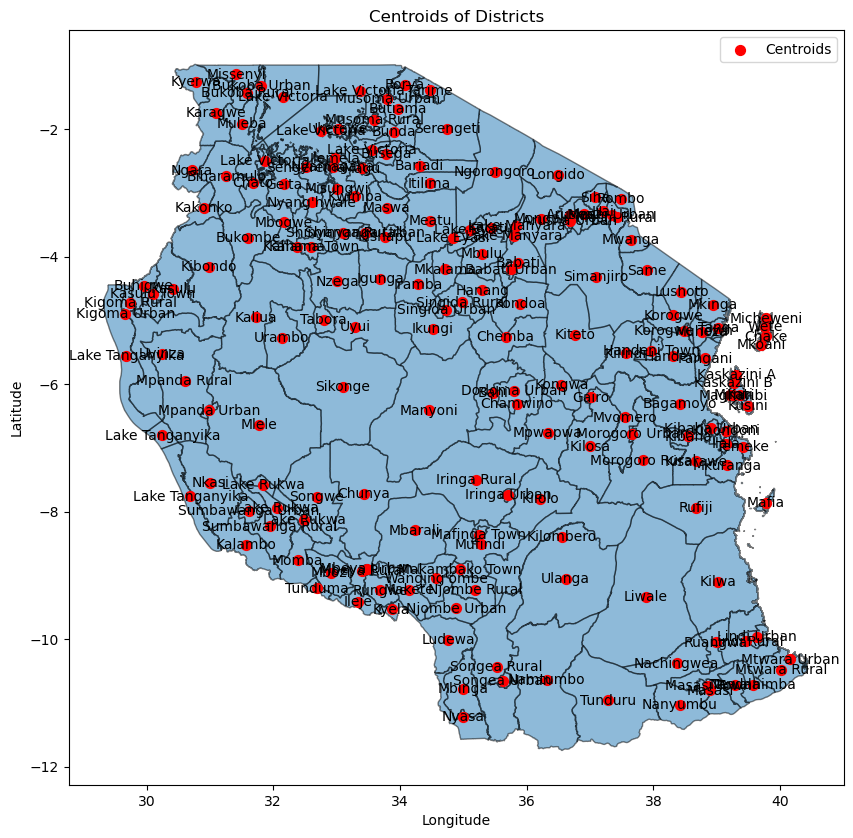

In [89]:
visualize_centroids('tanzania_data/tz_shapefiles/tz_districts.shp','region','district')

## Collecting Temperature Data
Understanding temperature patterns is crucial for agriculture as it impacts various aspects of crop growth, pest management, and water availability. By analyzing temperature trends over time, we can assess the vulnerability of agricultural systems to climate fluctuations and long-term changes which is essential factor for addessing food insecurity and improve agricultural resilience in the context of evolving climate conditions.Therefore in this section, we will be using [NASA's Power API](https://power.larc.nasa.gov/docs/services/api/temporal/monthly/) services to gather comprehensive temperature datasets spanning diverse geographic regions and temporal scales of monthly base. It provides parameters by year; the annual and each month's average, maximum, and/or minimum values. These data can be collected by single point and by regional.

### Single Point 

In [90]:
def fetch_temperature_data_point(lat, lon):
    
    '''
    Fetches temperature data from the NASA POWER API for a given latitude and longitude.

    Parameters:
        lat (float): Latitude of the location.
        lon (float): Longitude of the location.

    Returns:
        dict: A dictionary containing the fetched data if successful, None otherwise.
    '''
    
    parameters = {
        'latitude': lat,
        'longitude': lon,
        'start': '1990',         # Start year (YYYY)
        'end': '2022',           # End year (YYYY)
        'community': 'AG',       # Agroclimatology Archive
        'parameters': ','.join([
            'T2M',                # MERRA-2 Temperature at 2 Meters (C)
            'T2M_MAX',            # MERRA-2 Temperature at 2 Meters Maximum (C)
            'T2M_MIN',            # MERRA-2 Temperature at 2 Meters Minimum (C)
        ]),
        'format': 'json',        # Data format (json or csv)
        'temporalAverage': 'monthly'  # Temporal resolution (monthly)
    }

    # Make a GET request to the NASA POWER API
    response = requests.get('https://power.larc.nasa.gov/api/temporal/monthly/point', params=parameters)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Extract and return the data from the response
        return response.json()
    else:
        print("Failed to retrieve data. Status code:", response.status_code)
        return None

In [98]:
def compute_point_temperature(centroids_df):
    
    '''
    Calculates temperature data for each district centroid and returns a DataFrame.

    Parameters:
        centroids_df (DataFrame): DataFrame containing centroids (latitude and longitude) of each district.

    Returns:
        DataFrame: A DataFrame containing the calculated temperature data for each district centroid.
    
    '''
    # Initialize an empty list to store individual DataFrames
    all_data_frames = []

    # Loop over each row in the DataFrame
    for index, row in centroids_df.iterrows():
        latitude = row['centroid_lat']
        longitude = row['centroid_lon']
        district = row['district']
        region = row['region']

        # Fetch NASA data
        nasa_data = fetch_temperature_data_point(latitude, longitude)

        if nasa_data:
            # Convert the response to a pandas DataFrame
            nasa_df = pd.DataFrame(nasa_data['properties']['parameter'])

            # Add year, month, district, and region columns
            nasa_df['year'] = nasa_data['times']['data']
            nasa_df['month'] = [i % 12 + 1 for i in range(len(nasa_df))]
            nasa_df['district'] = district
            nasa_df['region'] = region

            # Reorder columns
            nasa_df = nasa_df[['region', 'district', 'year', 'month', 'T2M', 'T2M_MAX', 'T2M_MIN']]

            # Append DataFrame to the list
            all_data_frames.append(nasa_df)

    # Concatenate all DataFrames into a single DataFrame
    all_data = pd.concat(all_data_frames, ignore_index=True)
    
    return all_data

### Regional

In [92]:
def fetch_temperature_data_region(lat_min, lat_max, lon_min, lon_max):
    
    '''
    Fetches temperature data for a given region from the NASA POWER API.

    Parameters:
        lat_min (float): The minimum latitude of the region.
        lat_max (float): The maximum latitude of the region.
        lon_min (float): The minimum longitude of the region.
        lon_max (float): The maximum longitude of the region.

    Returns:
        dict: A dictionary containing the fetched temperature data, or None if the request failed.
    '''
    parameters = {
        'latitude-min': lat_min,
        'latitude-max': lat_max,
        'longitude-min': lon_min,
        'longitude-max': lon_max,
        'start': 1990,  # Start year (YYYY)
        'end': 2020,    # End year (YYYY)
        'community': 'ag',    # Agroclimatology Archive
        'parameters': ','.join([
            'T2M',                 # MERRA-2 Temperature at 2 Meters (C)
            'T2M_MAX',             # MERRA-2 Temperature at 2 Meters Maximum (C)
            'T2M_MIN',             # MERRA-2 Temperature at 2 Meters Minimum (C)
        ]),
        'format': 'json',       # Data format (json or csv)
        'temporalAverage': 'monthly'  # Temporal resolution (monthly)
    }

    # Make a GET request to the NASA POWER API
    response = requests.get('https://power.larc.nasa.gov/api/temporal/monthly/regional', params=parameters)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Extract and return the data from the response
        return response.json()
    else:
        print("Failed to retrieve data. Status code:", response.status_code)
        return None


In [93]:
def compute_regional_temperature(district_bounds_df):
    
    '''
    Calculates temperature data for each district region and returns a DataFrame.

    Parameters:
        district_bounds_df (DataFrame): DataFrame containing district bounds.

    Returns:
        DataFrame: A DataFrame containing the calculated temperature data for each district region.
    
    '''
    # Initialize an empty list to store individual DataFrames
    all_data_frames = []

    # Loop over each row in the DataFrame
    for index, row in district_bounds_df.iterrows():
        min_lat = row['min_lat']
        max_lat = row['max_lat']
        min_lon = row['min_lon']
        max_lon = row['max_lon']
        district = row['district']
        region = row['region']

        # Fetch NASA data
        nasa_data = fetch_temperature_data_region(min_lat, max_lat, min_lon, max_lon)

        if nasa_data:
            # Convert the response to a pandas DataFrame
            nasa_df = pd.DataFrame(nasa_data['properties']['parameter'])

            # Add year, month, district, and region columns
            nasa_df['year'] = nasa_df['parameter']['year']
            nasa_df['month'] = [i % 12 + 1 for i in range(len(nasa_df))]
            nasa_df['district'] = district
            nasa_df['region'] = region

            # Reorder columns
            nasa_df = nasa_df[['region', 'district', 'year', 'month', 'T2M', 'T2M_MAX', 'T2M_MIN']]

            # Append DataFrame to the list
            all_data_frames.append(nasa_df)

    # Concatenate all DataFrames into a single DataFrame
    all_data = pd.concat(all_data_frames, ignore_index=True)
    
    return all_data

### TANZANIA

In [99]:
#computing The Centroids of Distrcits
district_centroids = compute_centroids('tanzania_data/tz_shapefiles/tz_districts.shp','region','district')
district_centroids.head()

C:\Users\ashas\AppData\Local\Temp\ipykernel_31640\341830614.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.centroid


,region,district,centroid_lat,centroid_lon
0,Arusha,Arusha,-3.347952,36.688170
1,Arusha,Arusha Urban,-3.437964,36.675364
2,Arusha,Karatu,-3.554529,35.435120
3,Arusha,Lake Eyasi,-3.585394,35.109951
4,Arusha,Lake Manyara,-3.515286,35.836992


In [100]:
#data=fetch_temperature_data_point(-3.347952, 36.688170)
#data

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [36.68817, -3.347952, 1201.74]},
 'properties': {'parameter': {'T2M': {'199001': 22.65,
    '199002': 23.51,
    '199003': 21.68,
    '199004': 20.7,
    '199005': 19.55,
    '199006': 18.64,
    '199007': 17.95,
    '199008': 19.59,
    '199009': 21.35,
    '199010': 22.27,
    '199011': 22.47,
    '199012': 22.8,
    '199013': 21.08,
    '199101': 24.19,
    '199102': 25.5,
    '199103': 24.75,
    '199104': 22.93,
    '199105': 20.87,
    '199106': 19.33,
    '199107': 18.88,
    '199108': 19.6,
    '199109': 21.19,
    '199110': 22.92,
    '199111': 23.4,
    '199112': 23.51,
    '199113': 22.23,
    '199201': 24.76,
    '199202': 26.3,
    '199203': 25.8,
    '199204': 22.03,
    '199205': 19.85,
    '199206': 18.72,
    '199207': 17.95,
    '199208': 18.55,
    '199209': 20.69,
    '199210': 22.28,
    '199211': 22.4,
    '199212': 21.97,
    '199213': 21.76,
    '199301': 21.3,
    '199302': 22.31,
    '199303': 2

In [95]:
#Fetch the data
tz_temperature = compute_point_temperature(district_centroids)
tz_temperature.head()

KeyError: 'parameter'

In [39]:
# Save the combined monthly temperature data to a CSV file
tz_temperature.to_csv('tanzania_data/tz_monthly_temperature_data.csv', index=False)

In [40]:
def compute_region_temperature(input_csv, output_csv):
    # Read the input CSV file
    data_df = pd.read_csv(input_csv)

    # Initialize an empty list to store monthly temperature data
    all_temperature_data = []

    # Loop over each row in the DataFrame
    for index, row in data_df.iterrows():
        lat_min = row['min_lat']
        lat_max = row['max_lat']
        lon_min = row['min_lon']
        lon_max = row['max_lon']
        region = row['region']
        district = row['district']

        # Fetch temperature data for the region
        temperature_data = fetch_temperature_data_region(lat_min, lat_max, lon_min, lon_max)

        if temperature_data:
            # Extract temperature data for each month
            monthly_temperature = temperature_data['properties']['parameter']['T2M']

            # Convert temperature data to DataFrame
            monthly_temperature_df = pd.DataFrame(monthly_temperature)

            # Add year column
            monthly_temperature_df['year'] = monthly_temperature_df['month'].apply(lambda x: int(x[:4]))

            # Add month column and convert month number to month name abbreviation
            monthly_temperature_df['month'] = monthly_temperature_df['month'].apply(lambda x: calendar.month_abbr[int(x[4:])])

            # Add region and district columns
            monthly_temperature_df['region'] = region
            monthly_temperature_df['district'] = district

            # Append monthly temperature data to the list
            all_temperature_data.append(monthly_temperature_df)

    # Concatenate all monthly temperature DataFrames into a single DataFrame
    all_temperature_data_combined = pd.concat(all_temperature_data, ignore_index=True)

    # Reorder columns to have 'year', 'region', and 'district' first
    column_order = ['year', 'region', 'district'] + [col for col in all_temperature_data_combined.columns if col not in ['year', 'region', 'district']]
    all_temperature_data_combined = all_temperature_data_combined[column_order]

    # Save the combined monthly temperature data to a CSV file
    all_temperature_data_combined.to_csv(output_csv, index=False)


In [41]:
# Example usage:
compute_region_temperature('district_bounds.csv', 'region_temperature_data.csv')

Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status co

ValueError: No objects to concatenate

In [28]:
# Define a function to fetch temperature data from NASA POWER API for given latitude and longitude
def fetch_temperature_data(lat, lon):
    parameters = {
        'latitude': lat,
        'longitude': lon,
        'start': '19900101',  # Start date (YYYYMMDD)
        'end': '20211231',    # End date (YYYYMMDD)
        'community': 'AG',    # Agroclimatology Archive
        'parameters': ','.join([
            'T2M',                 # MERRA-2 Temperature at 2 Meters (C)
            'T2M_MAX',             # MERRA-2 Temperature at 2 Meters Maximum (C)
            'T2M_MIN',             # MERRA-2 Temperature at 2 Meters Minimum (C)
        ]),
        'format': 'json',       # Data format (json or csv)
        'temporalAverage': 'monthly'  # Temporal resolution (monthly)
    }

    # Make a GET request to the NASA POWER API
    response = requests.get('https://power.larc.nasa.gov/api/temporal/monthly/point', params=parameters)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Extract and return the data from the response
        return response.json()
    else:
        print("Failed to retrieve data. Status code:", response.status_code)
        return None

# Read latitude, longitude, and district name from CSV
data_df = pd.read_csv('districts_coordinates.csv')

# Initialize an empty list to store monthly temperature data
all_temperature_data = []

# Loop over each row in the DataFrame
for index, row in data_df.iterrows():
    latitude = row['latitude(y)']
    longitude = row['longitude(x)']
    district = row['district']


    # Fetch temperature data
    temperature_data = fetch_temperature_data(latitude, longitude)

    if temperature_data:
        # Extract temperature data for each month
        monthly_temperature = temperature_data['properties']['parameter']['T2M']

        # Convert temperature data to DataFrame
        monthly_temperature_df = pd.DataFrame(monthly_temperature)

        # Add month column and convert month number to month name abbreviation
        monthly_temperature_df['month'] = monthly_temperature_df['month'].apply(lambda x: calendar.month_abbr[x])

        # Add district column
        monthly_temperature_df['district'] = district

        # Append monthly temperature data to the list
        all_temperature_data.append(monthly_temperature_df)

# Concatenate all monthly temperature DataFrames into a single DataFrame
all_temperature_data_combined = pd.concat(all_temperature_data, ignore_index=True)

# Save the combined monthly temperature data to a CSV file
all_temperature_data_combined.to_csv("all_districts_monthly_temperature_data.csv", index=False)

Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status co

ValueError: No objects to concatenate

In [29]:
#THIS WORK


# Define a function to fetch data from NASA POWER API for given latitude and longitude
def fetch_nasa_data(lat, lon):
    parameters = {
        'latitude': lat,
        'longitude': lon,
        'start': '19900101',  # Start date (YYYYMMDD)
        'end': '20211231',    # End date (YYYYMMDD)
        'community': 'AG',    # Agroclimatology Archive
        'parameters': ','.join([
            'T2M',                 # MERRA-2 Temperature at 2 Meters (C)
            'T2M_MAX',             # MERRA-2 Temperature at 2 Meters Maximum (C)
            'T2M_MIN',             # MERRA-2 Temperature at 2 Meters Minimum (C)
              
        ]),
        'format': 'json',       # Data format (json or csv)
    }

    # Make a GET request to the NASA POWER API
    response = requests.get('https://power.larc.nasa.gov/api/temporal/daily/point', params=parameters)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Extract and return the data from the response
        return response.json()
    else:
        print("Failed to retrieve data. Status code:", response.status_code)
        return None

# Read latitude, longitude, and district name from CSV
#data_df = pd.read_csv('tz_districts_coordinate.csv')
data_df = pd.read_csv('districts_coordinates.csv')

# Initialize an empty list to store individual DataFrames
all_data_frames = []

# Loop over each row in the DataFrame
for index, row in data_df.iterrows():
    latitude = row['latitude(y)']
    longitude = row['longitude(x)']
    district = row['district']

    # Fetch NASA data
    nasa_data = fetch_nasa_data(latitude, longitude)

    if nasa_data:
        # Convert the response to a pandas DataFrame
        nasa_df = pd.DataFrame(nasa_data['properties']['parameter'])

        # Add district column
        nasa_df['district'] = district

        # Append DataFrame to the list
        all_data_frames.append(nasa_df)

# Concatenate all DataFrames into a single DataFrame
all_data = pd.concat(all_data_frames, ignore_index=True)

# Save the all_data DataFrame to a CSV file
all_data.to_csv("all_districts_meteo_data.csv", index=False)


In [42]:
import requests
import pandas as pd

def fetch_nasa_data_region(lat_min, lat_max, lon_min, lon_max):
    parameters = {
        'lat': f"{lat_min},{lat_max}",
        'lon': f"{lon_min},{lon_max}",
        'start': '1990',         # Start year (YYYY)
        'end': '2021',           # End year (YYYY)
        'community': 'AG',       # Agroclimatology Archive
        'parameters': ','.join([
            'T2M',                # MERRA-2 Temperature at 2 Meters (C)
            'T2M_MAX',            # MERRA-2 Temperature at 2 Meters Maximum (C)
            'T2M_MIN',            # MERRA-2 Temperature at 2 Meters Minimum (C)
        ]),
        'format': 'json',        # Data format (json or csv)
        'temporalAverage': 'monthly'  # Temporal resolution (monthly)
    }

    # Make a GET request to the NASA POWER API
    response = requests.get('https://power.larc.nasa.gov/api/temporal/monthly/regional', params=parameters)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Extract and return the data from the response
        return response.json()
    else:
        print("Failed to retrieve data. Status code:", response.status_code)
        return None

# Read latitude, longitude, and district name from CSV
data_df = pd.read_csv('district_bounds.csv')

# Initialize an empty list to store individual DataFrames
all_data_frames = []

# Loop over each row in the DataFrame
for index, row in data_df.iterrows():
    lat_min = row['min_lat']
    lat_max = row['max_lat']
    lon_min = row['min_lon']
    lon_max = row['max_lon']
    region = row['region']
    district = row['district']

    # Fetch NASA data for the region
    nasa_data = fetch_nasa_data_region(lat_min, lat_max, lon_min, lon_max)

    if nasa_data:
        # Convert the response to a pandas DataFrame
        nasa_df = pd.DataFrame(nasa_data['properties']['parameter'])

        # Add month and district columns
        nasa_df['month'] = [i % 12 + 1 for i in range(len(nasa_df))]
        nasa_df['district'] = district

        # Append DataFrame to the list
        all_data_frames.append(nasa_df)

# Concatenate all DataFrames into a single DataFrame
all_data = pd.concat(all_data_frames, ignore_index=True)

# Save the all_data DataFrame to a CSV file
all_data.to_csv("all_districts_monthly_meteo_data2.csv", index=False)


Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status code: 422
Failed to retrieve data. Status co

ValueError: No objects to concatenate